So, the overall goal here is to take a big text dataset where each document is represented by a high-dimensional feature vector, and arrive at a meaningful 2D visualization of those points.

For the example here, I'm using the abstracts of 20M+ publications from the Web of Science (WoS has a total of 50-60M papers, but only abstracts for those published after ~1991) to generate a Doc2Vec model that represents each document (abstract) as a 200 dimensional feature vector. I then visualize a random sample of 5M of these papers using a tool called LargeVis (doing more is totally possible, but the system I ran this particular analysis on had "only" 48GB RAM, and attempting more than 5M documents was giving me memory errors). You can of course use a similar procedure with other ways of representing documents (e.g. LDA).

### Step 1: Generate feature vectors

The particulars of the preprocessing I do here are unique to my data format, and to the fact that I'm using Gensim's implementaion of Doc2Vec, so I won't go into too much detail. The important thing (again assuming you're using Doc2Vec) is that you simply generate a single text file with one document per line. Don't forget to save some sort of index file so you know which line in your document file corresponds to which original document (we'll need that later when we want to enrich our visualization with metadata from the original documents).

In [ ]:
from gensim.models.doc2vec import Doc2Vec,TaggedLineDocument
import gzip,os,glob
import numpy as np

abs_dir = '/path/to/directory/with/abstracts'

# This just does some basic text clearning to separate all the words from any surrounding punctuation, 
def normalize_text(text):
    norm_text = text.lower()

    # Replace breaks with spaces 
    norm_text = norm_text.replace('|', ' ')

    # Pad punctuation with spaces on both sides
    for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
        norm_text = norm_text.replace(char, ' ' + char + ' ')

    return norm_text.strip()

def preprocess_docs(in_dir,out_dir):
    with gzip.open(in_dir+'uid_indices.txt.gz','wb') as idx_out, gzip.open(out_dir+'docs.txt.gz','wb') as docs:
        overall_total = 0
        files = glob.glob('{}/*.txt.gz'.format(in_dir))
        for f in files:
            if 'docs' or 'uid_indices' in f:
                continue
            print "Starting file {}".format(f)
            for i,line in enumerate(gzip.open(f)):
                uid,text = line.split('\t')
                if text.strip() == '':
                    continue
                docs.write(normalize_text(text)+'\n')
                idx_out.write(uid+'\n')
            total = i+1
            overall_total += total
            print "{} complete: {} total documents ({} overall)".format(f,total,overall_total)


preprocess_docs(abs_dir,abs_dir)


Now we run the actual Doc2Vec Model and save the results, which is all pretty straightforward. I'm using pretty standard parameters for Doc2Vec here, but there are good resources out there on parameter tuning if you're curious..

In [ ]:
# Generate a list of tagged line documents, one per line from the file generated above
documents = [doc for doc in TaggedLineDocument(abs_dir+'docs.txt.gz')]

# Now just run the model. A simple little one-liner. Be sure to take advantages of the the `workers` option, which parallelizes the model automagically
model = Doc2Vec(documents, size=200, window=5, min_count=5,workers=24)

# the resulting feature vectors are stored in `model.docvecs.doctag_syn0`, so let's just save that numpy array
np.save(abs_dir+'features-w2v-200.npy',model.docvecs.doctag_syn0)

# this is only really necessary if we're using t-sne for visualization (which is more well-known, but does not scale very nicely to really big datasets), as LargeVis automatically normalizes
"""
from sklearn.preprocessing import Normalizer
nrm = Normalizer('l2')
normed = nrm.fit_transform(model.docvecs.doctag_syn0)
np.save(abs_dir+'features_normed-w2v-200.npy',normed)
"""


### Step 2:  Generate our 2D embedding

Both [t-SNE](https://github.com/lvdmaaten/bhtsne) and [LargeVis](https://github.com/lferry007/LargeVis) have particular data formats they require, which are quite simple. T-SNE's python wrapper is actually easy to modify so that it reads the numpy array we generated above directly, but in any case I'm going to focus on using LargeVis in the standard way (though you could probably get it to work on numpy arrays directly if needed). This all assumes you've compiled and installed LargeVis following the instructions on their [Github repo](https://github.com/lferry007/LargeVis).

I typically just run LargeVis from the command line, but here I adapt [this script](https://github.com/lferry007/LargeVis) to run it in the notebook (with default parameters...see the [LargeVis paper](https://arxiv.org/abs/1602.00370) for details on tuning these).

In [4]:
# load features
features = np.load(abs_dir+'features-w2v-200.npy')

# for this example we're randomly sampling 5M of them, so here I sample and save the random indices of the sample
random_indices = np.random.choice(xrange(5000000),replace=False)
with open('indices_5M','w') as out:
    out.write(','.join(random_indices.asype(str)))
features = features[random_indices]

# now we write the data to file in the required LargeVis format (which requires a header with the number of items and the dimensionality of the feature vectors)
with open('lv_format.txt','w') as out:
    out.write("{}\t{}\n".format(*features.shape))
    for row in features:
        out.write('\t'.join(row.astype(str))+'\n')

In [ ]:
# now run Large Vis!
import LargeVis

# LargeVis doesn't take named arguments, so we have to pass all these explicitly, using -1 to indicate defaults 
# (this is handled more smoothly by argparse when calling from command line)

outdim = 2
threads = 24
samples = -1
prop = -1
alpha = -1
trees = -1
neg = -1
neigh = -1
gamma = -1
perp = -1

LargeVis.loadfile("lv_format.txt")

Y = LargeVis.run(outdim, threads, samples, prop, alpha, trees, neg, neigh, gamma, perp)

LargeVis.save("lv_output.txt")

Now we have out 2D embedding!

### Step 3: Visualization

Now let's walk through an example visualization pipeline. There are of course plenty of different things you could do here, but this example will hopefully give you the basics. We'll start with some preliminary imports, and define a little legend function we'll use below.

In [6]:
import numpy as np
import pandas as pd
import gzip
import graphlab as gl
from seaborn import color_palette,palplot
from IPython.core.display import display
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

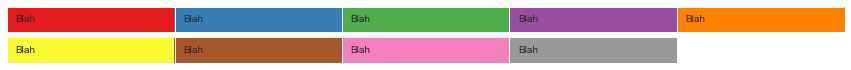

In [131]:
# Just a clunky little function to generate a legend (given color pallette and labels) as
# an independent matplotlib figure
def keyplot(pal, names):
    n = len(pal)
    rows = n / 5
    if n%5 > 0:
        rows += 1
    f, axes = plt.subplots(rows, 1, figsize=(15, .5*rows))
    if rows ==1:
        axes = [axes,]
    for idx,ax in enumerate(axes):
        current_pal = pal[idx*5:(idx*5)+5]
        if len(current_pal)<5:
            
            current_pal += ['white']*(5-len(current_pal))
        current_names = names[idx*5:(idx*5)+5]
        ax.imshow(np.arange(5).reshape(1, 5),
                  cmap=mpl.colors.ListedColormap(list(current_pal)),
                  interpolation="nearest", aspect="auto")
        ax.set_xticks(np.arange(5) - .5)
        ax.set_yticks([-.5, .5])
        for i,name in enumerate(current_names):
            ax.annotate(name,(-.45+i,0.1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# Example:
keyplot(color_palette('Set1',9),names=['Blah']*9)

Now, let's load our learned embedding indices of our random sample of documents into a Pandas dataframe:

In [8]:
# be sure to skip the header row that LargeVis generates
data = pd.read_table('wos_lv_output_5M.txt',header=None,skiprows=1,names=['x','y'],delimiter=' ')

indices = np.array(open('indices_5M').read().strip().split(','),dtype=int)
data['idx'] = indices

Now, for my case I have some Graphlab sframes in which I've previously stored a bunch of metadata on the abstracts we're modeling. Your data will surely be different (and the use of Graphlab here is totally incidental), but the gist of what I'm doing here is joining the xy coordinates from the LargeVis 2D embedding with the metadata.

In [9]:
uids = np.array([line.strip() for line in gzip.open('/path/to/uid_indices.txt.gz').readlines()])
uid_indices = gl.SFrame({'uid':uids[indices],'idx':indices})

This non-commercial license of GraphLab Create for academic use is assigned to jlorince@indiana.edu and will expire on May 03, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: U:\Users\jjl2228\AppData\Local\Temp\25\graphlab_server_1479318743.log.0


In [10]:
metadata = gl.SFrame('P:/Projects/WoS/WoS/parsed/metadata.sframe/')
cats = gl.SFrame('P:/Projects/WoS/WoS/parsed/categories.sframe')
joined = metadata.join(uid_indices,on='uid',how='inner').join(cats,on='uid',how='inner').to_dataframe()

In [127]:
plot_data = data.merge(joined,on='idx')

However you get there, waht you want is a pandas dataframe with one row per document, with the xy coordinates and whatever metadata you care about using to enrich your visualization. (Datashader, which we'll be using below, also works nicely with out-of-core Dask dataframes, so don't feel like you're limited to data structures that fit in memory!). For the purposes of this example, the only metadata I care about is the WoS subheading for each paper, and the WoS-assigned subject categories.

In [128]:
plot_data = plot_data[['x','y','subheading','categories']]
plot_data.head()

,x,y,subheading,categories
0,-0.947329,-3.782668,Life Sciences & Biomedicine,Pharmacology & Pharmacy
1,-6.668430,7.766551,Life Sciences & Biomedicine,Biology|Mathematical & Computational Biology
2,-16.014929,14.479502,Physical Sciences,Mathematics
3,10.640243,-16.039352,Life Sciences & Biomedicine,"Oncology|Radiology, Nuclear Medicine & Medical..."
4,-21.193598,0.940371,,Criminology & Penology


Now, datashader requires that we explicitly represent categorical data as categorical data types, so let's do that

In [129]:
plot_data['subheading'] = plot_data['subheading'].astype('category')

Let's also simplfify the category data by just looking as the first category assigned to each paper. We *won't* convert to categorical data yet, as we need to do some other preprocessing of the category data below first.

In [130]:
plot_data['top_cat'] = plot_data['categories'].apply(lambda x: x.split('|')[0].lower())


Now we're (almost) ready to actually generate some visuals! There's a bit of boilerplate we'll want to start with for datashader. MOst of is adapted from [this tutorial](https://anaconda.org/jbednar/census/notebook). 

In [29]:
# this is critical. Datashader depends on defining an image of a specified size in pixels
plot_width  = int(500)
plot_height = int(500)
background = "black"

import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

# this function actually generates the datashader image 
export = partial(export_image, background = background, export_path="export")

# this handles colorinzing of the image
cm = partial(colormap_select, reverse=(background!="black"))

Now we can make an image with datashader. In the words of datashaders's readme:
> Datashader is a graphics pipeline system for creating meaningful representations of large amounts of data. It breaks the creation of images into 3 main steps: 
1. Projection: Each record is projected into zero or more bins, based on a specified glyph.
2. Aggregation: Reductions are computed for each bin, compressing the potentially large dataset into a much smaller aggregate.
3. Transformation: These aggregates are then further processed to create an image.

In terms of code, that requires that we (1) define a canvas, (2) define our (aggregated) glyphs, and (3) define the transformation function that turns the aggreagation into an image. Note that I'm just saving all my images as "tempfile" since I'm just working in the notebook anyway.

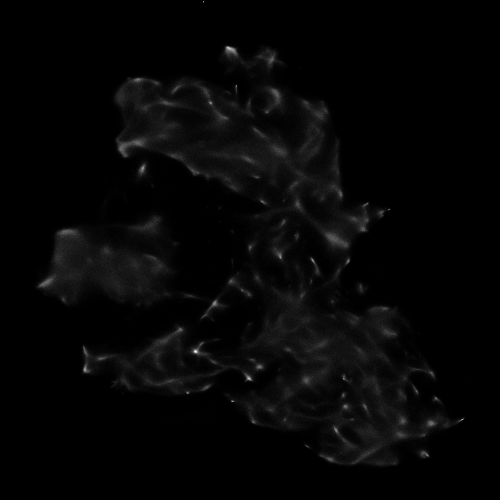

In [40]:
# define canvas of a specified dimension
cvs = ds.Canvas(plot_width, plot_height)
# aggregate *point* data into bins specified by the size of our image
# this amounts to defining a value for each *pixel* in the image
agg = cvs.points(plot_data, 'x', 'y')
# now use a transfer function to draw the image. In this case we shade each pixel 
# based on the number of of observations falling within each pixel
export(tf.shade(agg, cmap = cm(Greys9), how='linear'),'tempfile')


Pretty neat (and as you'll see when you try running it, *fast* too). But because the point density is pretty low for any given pixel, the structure is hard to see. We can fix this by using a non-linear shading scheme, like eq_hist (logarithmic shading is also an option). From the tutorial linked above:
> ...let's try the image-processing technique called histogram equalization. I.e., given a set of raw counts, map these into a range for display such that every available color on the screen represents about the same number of samples in the original dataset. The result is similar to that from the log transform, but is now non-parametric -- it will equalize any linearly or nonlinearly distributed integer data, regardless of the distribution:

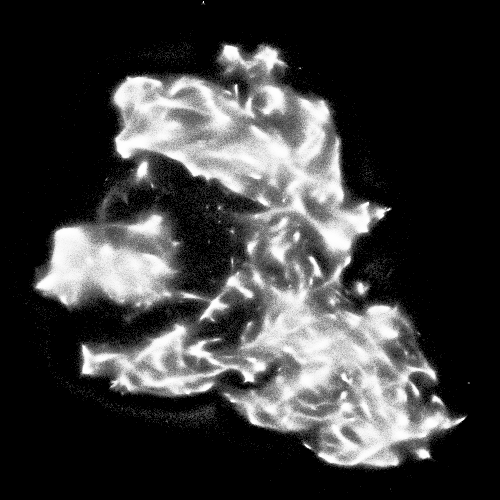

In [41]:
export(tf.shade(agg, cmap = cm(Greys9), how='eq_hist'),'tempfile')


Ok, that looks better, and we have some nice structure. But of course we don't know yet if this is just a pretty picture, or actually captures something meaningful about our data. Now let's look at some methods for incorporating metadata that will help resolve this.

To accomplish, we're going to define a more sophisticated plotting function that will colorize points based on either (a) the WoS subheading, or (b) the top category for each paper. In the latter case, there are more categories than distinguishable colors, so we'll design the function to only draw the top N most popular categoeries (for the example I'll use 9, which is about the max number of colors I've found that is easy to distinguish).

In [140]:
# `cat` specifies which categorical column we want to color by, and topN limits plotting to the top N most common categories in that column
def create_image(w=plot_width, h=plot_height,cat=None,color_key=None,topN=None):
    # if we specify a `topN`, determined which are the top N most commmon categories, and limit the dataframe to the corresponding rows
    if topN is not None:
        topN = plot_data[cat].value_counts()[:topN].index.values
        df = plot_data[plot_data[cat].isin(topN)].copy()
    else:
        df = plot_data
    # now that we've done our sampling we can convert the column to a category type
    df[cat] = df[cat].astype('category')
    # unless we explicitly pass a {category:color} dictionary, generate the color map
    if color_key is None:
        unique_values = sorted(df[cat].unique())
        # this is s kludge to handle the fact that some plotting libraries don't handle seaborn color paletes well (just converting to hex color names)
        colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette('Set1',n_colors=len(unique_values)))).astype(int)]
        # use matplotlib to draw a legend
        keyplot(colors,unique_values)
        color_key = {val:color for val,color in zip(unique_values,colors)}    
        
    # now the plotting command is the sameas above, except we use a `color_key` arugment to tell datashader how to color each point
    cvs = ds.Canvas(plot_width=w, plot_height=h)
    agg = cvs.points(df, 'x', 'y', ds.count_cat(cat))
    img = tf.shade(agg, color_key=color_key, how='eq_hist')
    return img

So let's run this code, colorizing by WoS subheading:

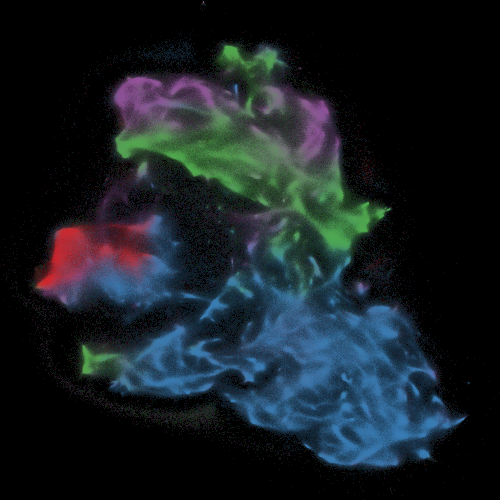

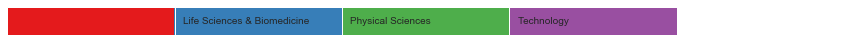

In [141]:
export(create_image(cat='subheading'),'tempfile')

There we go! While it's not perfect, we can clearly see that papers that cluster together in the Doc2Vec feature space also tend to be within the same broad category according to WoS (note that blue is blank because it corresponds to the social sciences and humanities top level WoS heading, for which there are no subheadings). To see the organization at a finer granularity, let's do the same thing, but colored by the top 9 most common subject categories:

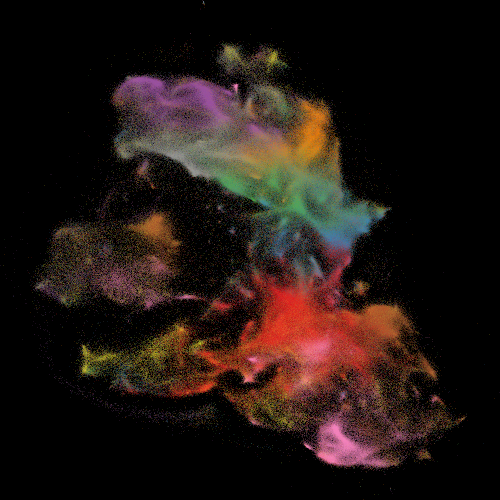

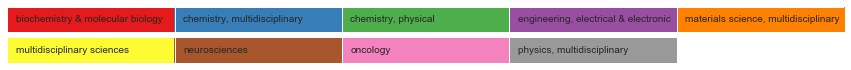

In [142]:
export(create_image(cat='top_cat',topN=9),'tempfile')


While it's not quite as clean, and of course sparser (because we're looking at a much smaller subset of papers), we can again see an impressive level of coherent organization, even though we had to go through a lot of preprocessing steps to get here.

### Going further...

To wrap up, I want to close with some further ideas on cool directions to go with datashader visualization. First off, for those you who are used to working with Matplotlib (like me!) datashader is undoubtedly awesome, but doesn't make it easy to do seemingly basic things like annotation, axis labels, etc. Luckily there is a workaround. Because datashader generates rasterized images, it's actually pretty straightforward to import pull them into a matplotlib figure with `imread` and `imshow`, and then layer traditional matplotlib visual elements on top of them, like so:

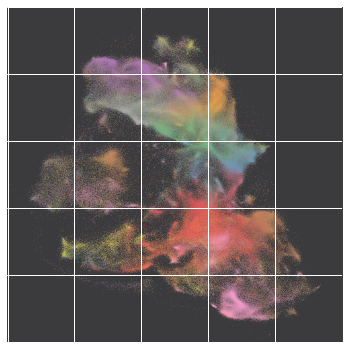

In [155]:
from scipy.misc import imread

# standard matplotlib figure creation
fig,ax = plt.subplots(1,1,figsize=(6,6))
# load our saved image, and make it the backgroudn of our figured (with a slighly reduced alpha)
img = imread('export/tempfile.png')
ax.imshow(img,alpha=.75)
ax.set_xticklabels([])
ax.set_yticklabels([]);


From here, you can add anything you want to the image using the matplotlib (or seaborn, or whatever, that you're used to). Just be cautious about making to scale the matplotlib axis elements appropriately to your raster image. As a more practical example (from a differnt project) here's a similarity matrix I generated for 10,000 musical artists from last.fm (so yes, datshader here is actually plotting 100 million datapoints, and it handles this scale of data with no problems whatsoever):

<img src='music_sim_2.png' align="left"/>

Using the same process as above, I imported my datashader png image into a matplotlib figure,defined custom tick labels and locations, and used `axhline` and `axvline` to annotate the image. Here artists are sorted by genre, and I label the regions of the image corresponding to each genre.

The last thing I'll introduce (only briefly) is interactive plotting. Datshader actually interacts very nicely with Bokeh to genrate interactive plots. The results of this won't display nicely in the browser, so for now I'll just share the code and some screenshots.

The process is actually fairly simple, and requires that you first define a base Bokeh plot: 

In [158]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()
x_range = (-24,20)
y_range = (-24,24)

def base_plot(tools='pan,wheel_zoom,reset,box_zoom',webgl=False):
    p = bp.figure(tools=tools,
        plot_width=500, plot_height=500,
         outline_line_color=None, x_range=x_range, y_range=y_range,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, webgl=webgl)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.background_fill_color = "black"
    
    return p

Loading BokehJS ...

Next we define an image callback function (which is essentially the same as the image creation code we used before), and then generate the interactive image:

In [160]:
def image_callback(x_range=x_range,y_range=y_range,w=plot_width, h=plot_height,cat='top_cat',color_key=None,topN=9):
   
    if topN is not None:
        topN = plot_data[cat].value_counts()[:topN].index.values
        df = plot_data[plot_data[cat].isin(topN)].copy()
    else:
        df = plot_data.copy()
       
    if color_key is None:
        unique_values = sorted(df[cat].unique())
        colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette('Set1',n_colors=len(unique_values)))).astype(int)]
        keyplot(colors,unique_values)
        color_key = {val:color for val,color in zip(unique_values,colors)}
    
    df[cat] = df[cat].astype('category')
    
    cvs = ds.Canvas(plot_width=w, plot_height=h,x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat(cat))
    img = tf.shade(agg, color_key=color_key, how='eq_hist')
    # dynspread just makes points expand a bit when you zoom in
    return tf.dynspread(img,threshold=0.75, max_px=8)

# commenting these out because they won't work on a static webpage
#p = base_plot()
#InteractiveImage(p, image_callback)

Again, you'll have to run this yourself to get the interactive version, but what you end up should look something like this (note the interaction controls in the corner):

<img src="screenshot1.png" align="left" />


Where the real power of combining Datashader and Bokeh shows is when you zoom in:

<img src="screenshot2.png" align="left" />

When you zoom, Datashader dynamically re-renders the visualizaion to increase the granulrity. It's awesome to see in action, and I strongly recommend you look at the Datashader [census tutorial](https://anaconda.org/jbednar/census/notebook) to see some exceptionally elegant illustrations of how data rendering at different zoom levels works.

Well, that's all for now. Please feel free to reach out (jared.j.lorince (at) gmail (dot) com) with any thoughts or questions!